## Machine Learning algorithms used:
LogisticRegression(LR), RandomForestClassifier(RF), XGBoostingClassifier(XG), ExtraTreesClassifier(ET), FeedForwardNeuralNetwork(NN)

## Performance metric
Classification accuracy

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.gridspec as gridspec

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from keras.models import Model
from keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('ignore')

/Users/himanshu/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load the Dataset

In [4]:
# Put the file path to the dataset in the variable.
# The dataset has a column called row_id which acts as the index

filepath = 'data.csv'
data = pd.read_csv(filepath,index_col='row_id')

# Exploratory Data Analysis

In [6]:
print("Dataset:\t\t\t", data.shape)

print("Missing Values:\t\t\t",data.isnull().sum().sum())

print("Duplicate Values:\t\t",data.duplicated(keep='first').sum())

Dataset:			 (200000, 287)
Missing Values:			 0
Duplicate Values:		 76007


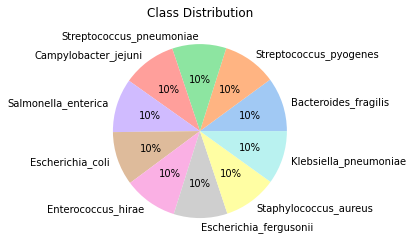

In [7]:
# Checking the target distribution in the dataset

target_distrib = pd.DataFrame({
    'count':data['target'].value_counts(),
    'share':data['target'].value_counts() / data.shape[0] * 100
})
colors = sns.color_palette('pastel')[0:10]
plt.pie(target_distrib['count'],labels = target_distrib.index, colors = colors, autopct = '%.0f%%')
plt.title("Class Distribution")
plt.show()

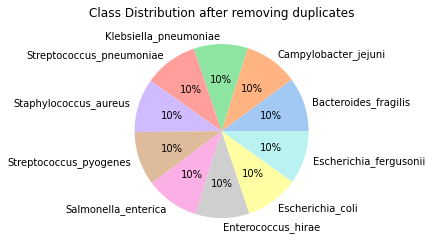

In [8]:
# Checking the target distribution without the duplicate samples

target_distrib_wod = pd.DataFrame({
    'count':data.drop_duplicates(ignore_index=True)['target'].value_counts(),
    'share':data.drop_duplicates(ignore_index=True)['target'].value_counts() / data.shape[0] * 100
})
colors = sns.color_palette('pastel')[0:10]
plt.pie(target_distrib_wod['count'],labels = target_distrib_wod.index, colors = colors, autopct = '%.0f%%')
plt.title("Class Distribution after removing duplicates")
plt.show()

## Plotting the features

### Distribution of first 100 features

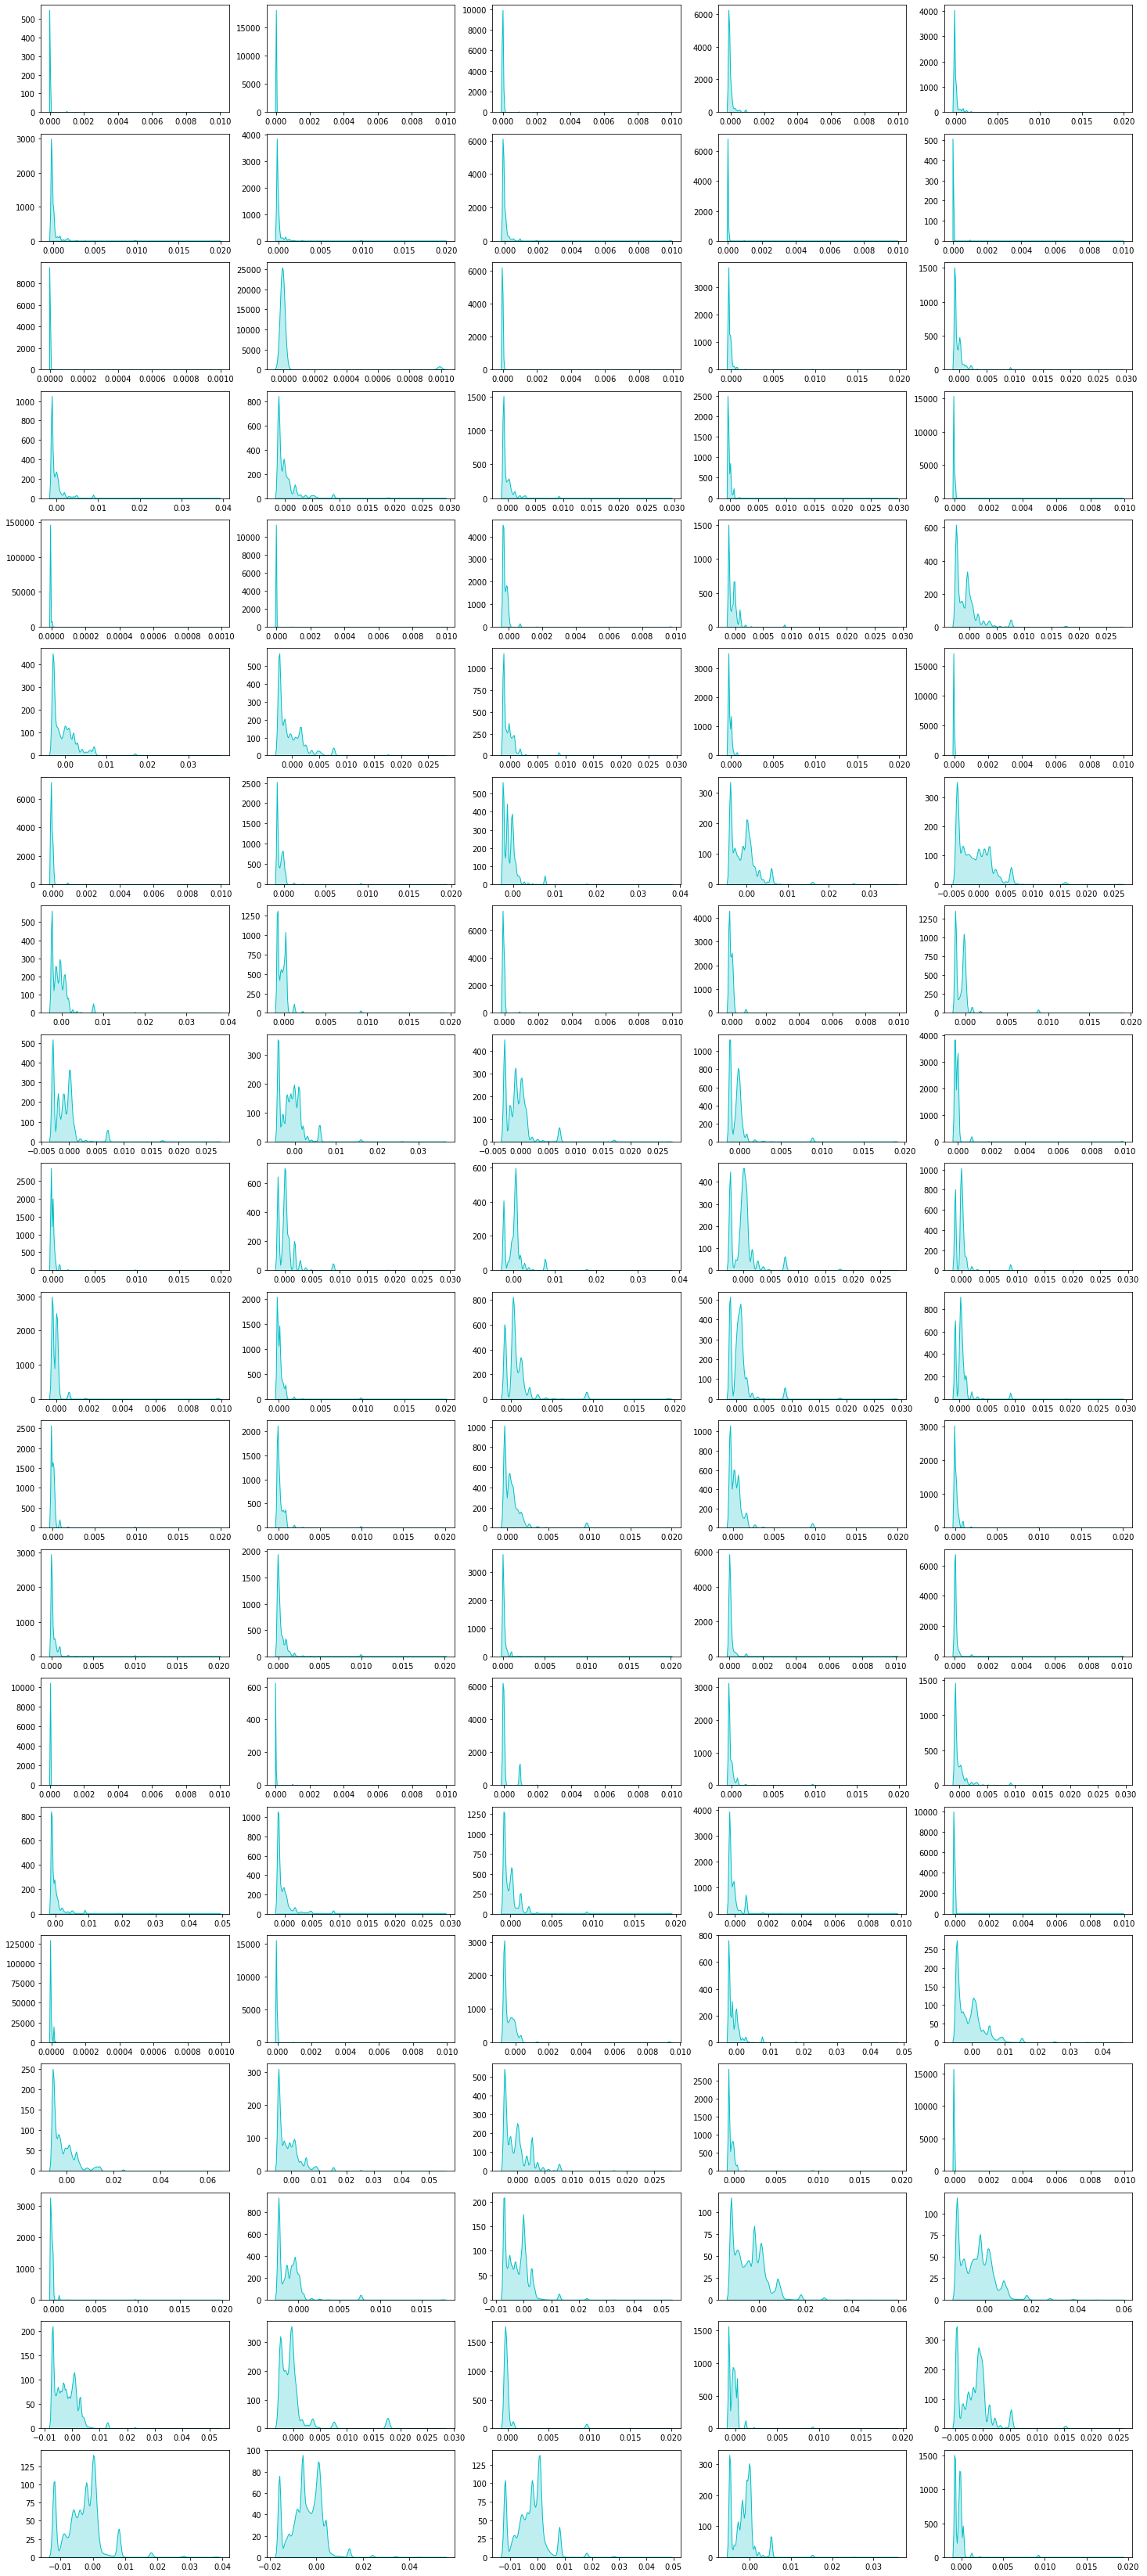

In [9]:
features = [col for col in data.columns if col not in ['target']]
ncols = 5
nrows = 20
n_features = features[:100]
fig,axes = plt.subplots(nrows,ncols,figsize=(25,15*4))

for r in range(nrows):
    for c in range(ncols):
        col = n_features[r*ncols+c]
        sns.kdeplot(x=data[col], ax=axes[r,c], color='#00BFC4',fill=True)
        axes[r,c].set_ylabel('')
        axes[r,c].set_xlabel('')
plt.show()

### Distribution of 101-200 features

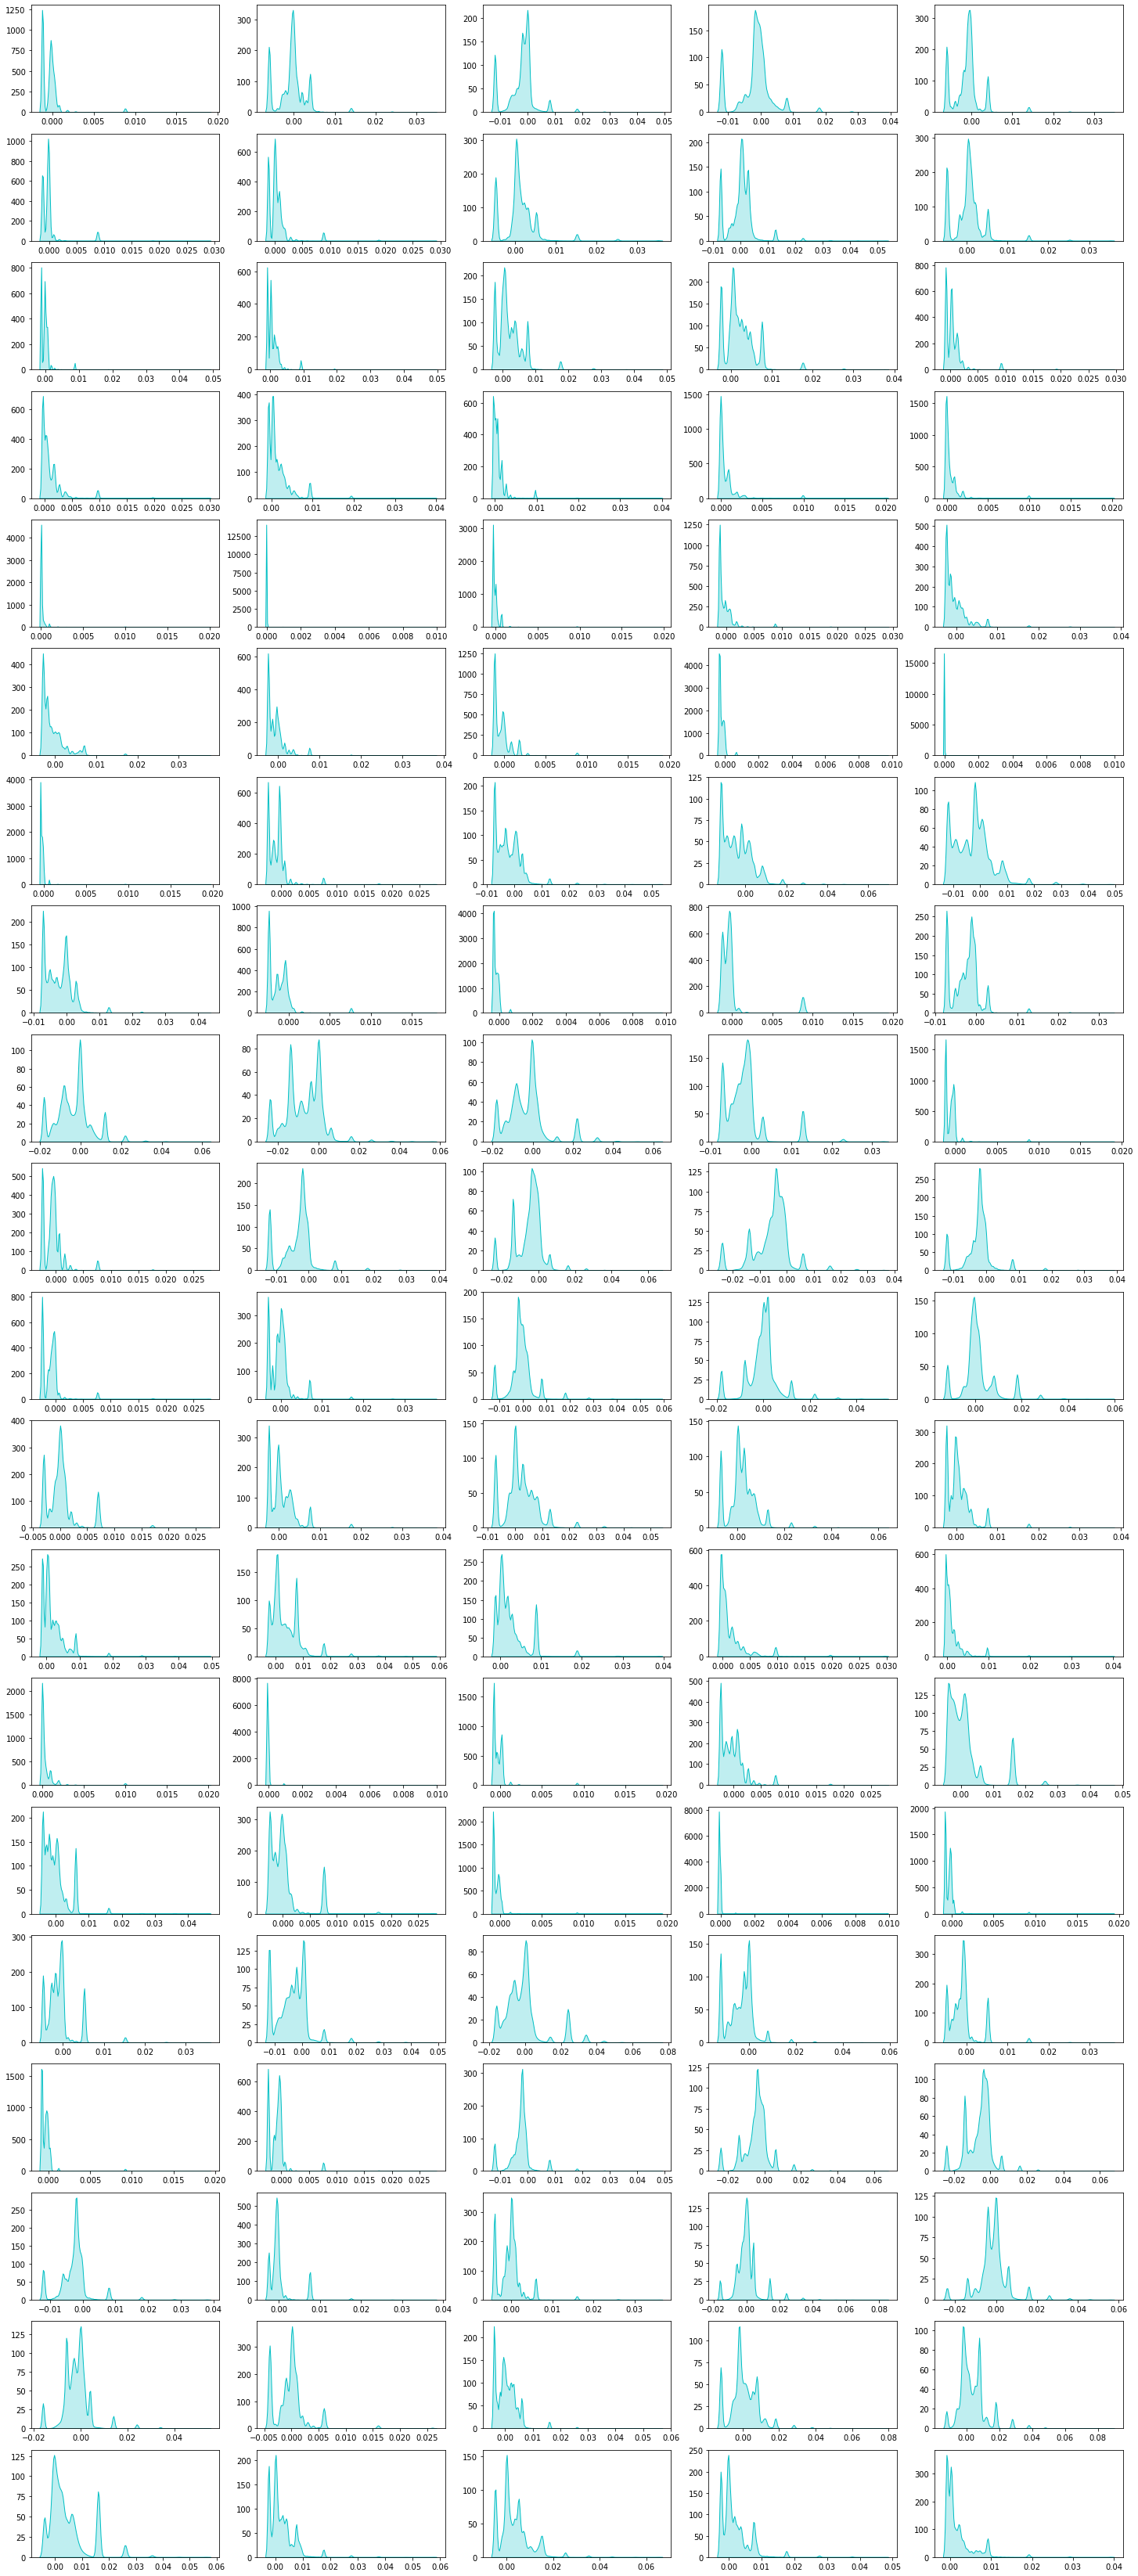

In [10]:
ncols = 5
nrows = 20
n_features = features[100:200]
fig,axes = plt.subplots(nrows,ncols,figsize=(25,15*4))

for r in range(nrows):
    for c in range(ncols):
        col = n_features[r*ncols+c]
        sns.kdeplot(x=data[col], ax=axes[r,c], color='#00BFC4',fill=True)
        axes[r,c].set_ylabel('')
        axes[r,c].set_xlabel('')
plt.show()

### Distribution of 201-286 features

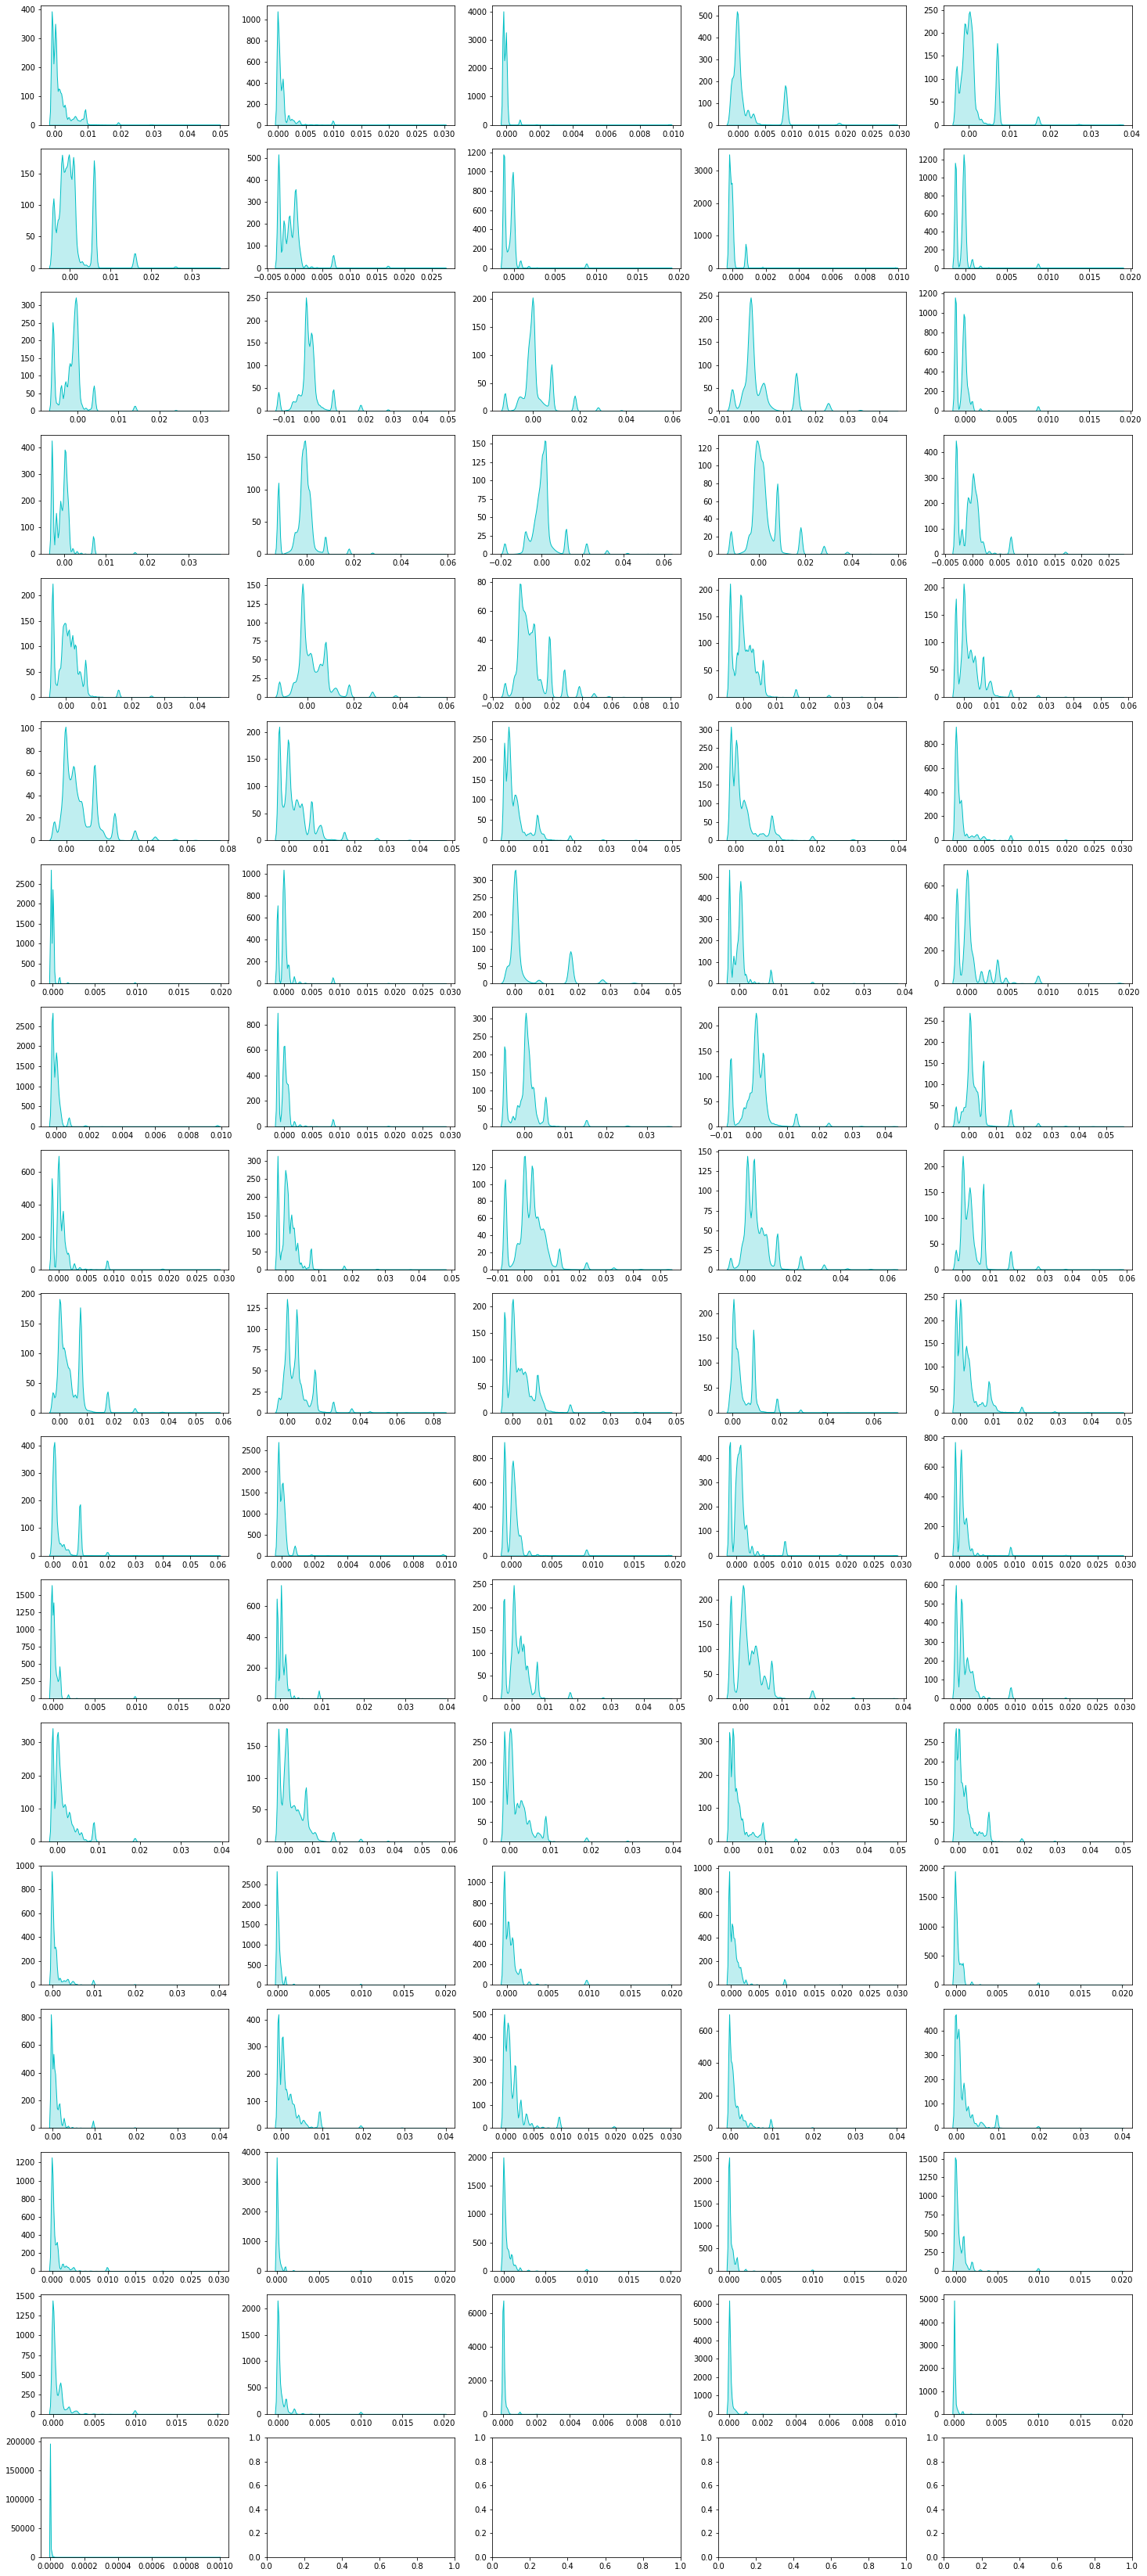

In [11]:
ncols = 5
nrows = 18
n_features = features[200:]
fig,axes = plt.subplots(nrows,ncols,figsize=(25,15*4))

for r in range(nrows):
    for c in range(ncols):
        if(r*ncols+c < 86):
            col = n_features[r*ncols+c]
            sns.kdeplot(x=data[col], ax=axes[r,c], color='#00BFC4',fill=True)
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel('')
plt.show()

In [12]:
# Checking the description of the dataset

data.describe()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
count,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05
mean,6.421457e-07,-0.000003,-0.000014,-0.000010,0.000005,0.000025,0.000014,-0.000009,-0.000028,-0.000008,...,0.000135,0.000348,0.000253,0.000464,0.000581,0.000379,0.000062,8.982134e-05,1.170014e-04,2.215407e-07
std,8.654927e-05,0.000132,0.000287,0.000436,0.000683,0.000869,0.000775,0.000441,0.000107,0.000083,...,0.000711,0.001117,0.000914,0.001238,0.001528,0.001182,0.000466,5.475606e-04,6.788277e-04,2.050081e-05
min,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
25%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
50%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000237,-0.000199,-0.000114,-0.000043,-0.000010,...,0.000014,0.000064,0.000047,0.000124,0.000114,0.000043,-0.000010,4.632568e-07,4.632568e-07,-9.536743e-07
75%,-9.536743e-07,-0.000003,-0.000013,-0.000004,-0.000011,0.000003,-0.000030,0.000004,-0.000028,-0.000010,...,0.000111,0.000463,0.000297,0.000684,0.000774,0.000365,0.000030,6.046326e-05,6.946326e-05,-9.536743e-07
max,9.999046e-03,0.009990,0.009957,0.009886,0.019800,0.019760,0.019800,0.009886,0.009957,0.009990,...,0.019957,0.019914,0.019957,0.019914,0.019914,0.019957,0.009990,9.990463e-03,1.999046e-02,9.990463e-04


# Data Preprocessing

In [5]:
# Encoding our string class values to integer values
encoder = LabelEncoder()
data['target'] = encoder.fit_transform(data['target'])

In [6]:
# Splitting our data into a training set (80%) and testing set (20%)
train, test = train_test_split(data,test_size=0.2,stratify=data['target'],random_state=42)

In [7]:
# Removing duplicates while assigning sample weight to each sample
train2 = pd.DataFrame(
    [list(tup) for tup in train.value_counts().index.values],
    columns = train.columns
)
train2['sample_weight'] = train.value_counts().values

In [8]:
# Splitting the training and testing set into Xtrain, ytrain, Xtest and ytest

Xtrain = train2.drop(['target','sample_weight'],axis=1)
ytrain = train2['target']
sample_weights = train2['sample_weight']

Xtest = test.drop('target',axis=1)
ytest = test['target']

In [9]:
print("Number of values in training set:\t",Xtrain.shape[0])
print("Number of values in testing set:\t",Xtest.shape[0])

Number of values in training set:	 104996
Number of values in testing set:	 40000


# Logistic Regression

In [15]:
model_lr = LogisticRegression(random_state=42,max_iter=500)
model_lr.fit(Xtrain,ytrain,sample_weight=sample_weights)

LogisticRegression(max_iter=500, random_state=42)

In [16]:
ypred_train_lr = model_lr.predict(Xtrain)
ypred_test_lr = model_lr.predict(Xtest)

In [17]:
accuracy_train_lr = accuracy_score(ytrain,ypred_train_lr)
accuracy_test_lr = accuracy_score(ytest,ypred_test_lr)

In [18]:
print("Training Accuracy:\t",accuracy_train_lr)
print("Testing Accuracy:\t",accuracy_test_lr)

Training Accuracy:	 0.6872071317002553
Testing Accuracy:	 0.664025


# Random Forest Classifier

In [23]:
model_rf = RandomForestClassifier(n_estimators=4000,
                              max_depth=None,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              min_impurity_decrease=0.0001,
                              bootstrap=True,
                              oob_score=True,
                              n_jobs=-1,
                              random_state=42,
                              verbose=1)

In [25]:
model_rf.fit(Xtrain,ytrain,sample_weight=sample_weights)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2438 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  7.1min finished


CPU times: user 45min 39s, sys: 2.84 s, total: 45min 41s
Wall time: 10min 36s


RandomForestClassifier(min_impurity_decrease=0.0001, n_estimators=4000,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=1)

In [26]:
ypred_train_rf = model_rf.predict(Xtrain)
ypred_test_rf = model_rf.predict(Xtest)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:    5.8s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:    8.3s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:   14.9s
[Parallel(n_jobs=6)]: Done 4000 out of 4000 | elapsed:   18.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done 1238 

CPU times: user 2min 43s, sys: 1.24 s, total: 2min 44s
Wall time: 28.7 s


[Parallel(n_jobs=6)]: Done 4000 out of 4000 | elapsed:   10.0s finished


In [27]:
accuracy_train_rf = accuracy_score(ytrain,ypred_train_rf)
accuracy_test_rf = accuracy_score(ytest,ypred_test_rf)

CPU times: user 9.68 ms, sys: 139 µs, total: 9.81 ms
Wall time: 8.44 ms


In [28]:
print("Training Accuracy:\t",accuracy_train_rf)
print("Testing Accuracy:\t",accuracy_test_rf)

Training Accuracy:	 0.9827802963922435
Testing Accuracy:	 0.968625
CPU times: user 443 µs, sys: 0 ns, total: 443 µs
Wall time: 346 µs


# XGBoosting Classifier

In [29]:
model_xg = XGBClassifier(base_score=0.5,
                      learning_rate=0.1,
                      max_depth=3,
                      n_estimators=1000,
                      n_jobs=-1,
                      objective='multi:softprob',
                      random_state=42,
                      reg_alpha=1,
                      reg_lambda=0,
                      seed=None,
                      verbosity=1,
                      use_label_encoder=False)

In [30]:
model_xg.fit(Xtrain,ytrain,sample_weight=sample_weights)

[19:18:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2h 55min 11s, sys: 308 ms, total: 2h 55min 11s
Wall time: 29min 20s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=1, reg_lambda=0, scale_pos_weight=None,
              seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [31]:
ypred_train_xg = model_xg.predict(Xtrain)
ypred_test_xg = model_xg.predict(Xtest)

CPU times: user 23.5 s, sys: 17.2 ms, total: 23.5 s
Wall time: 4.27 s


In [38]:
accuracy_train_xg = accuracy_score(ytrain,ypred_train_xg)
accuracy_test_xg = accuracy_score(ytest,ypred_test_xg)

In [39]:
print("Training Accuracy:\t",accuracy_train_xg)
print("Testing Accuracy:\t",accuracy_test_xg)

Training Accuracy:	 0.9841708255552593
Testing Accuracy:	 0.970825


# Extra Trees Classifier

In [37]:
model_et = ExtraTreesClassifier(n_estimators=100,
                            n_jobs=-1,
                            random_state=42)

In [40]:
model_et.fit(Xtrain,ytrain,sample_weight=sample_weights)

CPU times: user 34.4 s, sys: 323 ms, total: 34.7 s
Wall time: 6.09 s


ExtraTreesClassifier(n_jobs=-1, random_state=42)

In [41]:
ypred_train_et = model_et.predict(Xtrain)
ypred_test_et = model_et.predict(Xtest)

CPU times: user 6.74 s, sys: 109 ms, total: 6.85 s
Wall time: 1.32 s


In [42]:
accuracy_train_et = accuracy_score(ytrain,ypred_train_et)
accuracy_test_et = accuracy_score(ytest,ypred_test_et)

print("Training Accuracy:\t",accuracy_train_et)
print("Testing Accuracy:\t",accuracy_test_et)

Training Accuracy:	 1.0
Testing Accuracy:	 0.994425


# FeedForward Neural Network

In [19]:
ytrain_categorical = to_categorical(ytrain,num_classes=10)

input_seq = Input(shape=Xtrain.shape[1])
hidden = Dense(200,activation='tanh')(input_seq)
hidden2 = Dense(105,activation='tanh')(hidden)
output_seq = Dense(10,activation='softmax')(hidden2)

Metal device set to: Apple M1


2022-04-15 19:56:19.424901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-15 19:56:19.425303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
model_nn = Model(input_seq,output_seq)

In [ ]:
model_nn.summary()

In [21]:
model_nn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_nn.fit(Xtrain,ytrain_categorical,sample_weight=sample_weights,epochs=100,verbose=2)

In [23]:
ypred_train_nn = model_nn.predict(Xtrain)
ypred_test_nn = model_nn.predict(Xtest)

In [24]:
ypred_train_nn = np.argmax(ypred_train_nn,axis=1)
ypred_test_nn = np.argmax(ypred_test_nn,axis=1)

In [ ]:
accuracy_train_nn = accuracy_score(ytrain,ypred_train_nn)
accuracy_test_nn = accuracy_score(ytest,ypred_test_nn)

print("Training Accuracy:\t",accuracy_train_nn)
print("Testing Accuracy:\t",accuracy_test_nn)

# Results

## Feature Importances

In [47]:
imp_rf = pd.DataFrame({
    'feature':Xtrain.columns,
    'importance':model_rf.feature_importances_})

imp_xg = pd.DataFrame({
    'feature':Xtrain.columns,
    'importance':model_xg.feature_importances_})

imp_et = pd.DataFrame({
    'feature':Xtrain.columns,
    'importance':model_et.feature_importances_})

In [61]:
imp_rf_100 = imp_rf.sort_values(by='importance', ascending=False).iloc[0:100,:].reset_index(drop=True)
imp_xg_100 = imp_xg.sort_values(by='importance', ascending=False).iloc[0:100,:].reset_index(drop=True)
imp_et_100 = imp_et.sort_values(by='importance', ascending=False).iloc[0:100,:].reset_index(drop=True)

In [ ]:
fig = make_subplots(rows=1,cols=3,subplot_titles=("RandomForest","XGBoosting", "ExtraTrees"))

fig.add_trace(
    go.Bar(
        x=imp_rf_100.importance,
        y=imp_rf_100.feature,
        orientation='h',
        marker=dict(color=imp_rf_100.importance)
        ),row=1,col=1
        )
fig.add_trace(
    go.Bar(
        x=imp_xg_100.importance,
        y=imp_xg_100.feature,
        orientation='h',
        marker=dict(color=imp_xg_100.importance)
        ),row=1,col=2
        )
fig.add_trace(
    go.Bar(
        x=imp_et_100.importance,
        y=imp_et_100.feature,
        orientation='h',
        marker=dict(color=imp_et_100.importance)
        ),row=1,col=3
        )

fig.update_layout(
    title_text = 'Feature importance',
    height=500,
    xaxis_title_text ='Importance',
    yaxis1_title_text = 'Features',
    yaxis=dict(autorange='reversed'),
    xaxis2_title_text ='Importance',
    yaxis2=dict(autorange='reversed'),
    xaxis3_title_text ='Importance',
    yaxis3=dict(autorange='reversed')
)
fig.show()

## Confusion Matrix

In [76]:
labels = data['target'].unique().tolist()

In [78]:
labels = encoder.inverse_transform(labels)

In [90]:
cm_lr = confusion_matrix(ytest, ypred_test_lr)
cm_rf = confusion_matrix(ytest, ypred_test_rf)
cm_xg = confusion_matrix(ytest, ypred_test_xg)
cm_et = confusion_matrix(ytest, ypred_test_et)
cm_nn = confusion_matrix(ytest, ypred_test_nn)

In [91]:
cmn_lr = cm_lr.astype('float') / cm_lr.sum(axis=1)
cmn_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)
cmn_xg = cm_xg.astype('float') / cm_xg.sum(axis=1)
cmn_et = cm_et.astype('float') / cm_et.sum(axis=1)
cmn_nn = cm_nn.astype('float') / cm_nn.sum(axis=1)

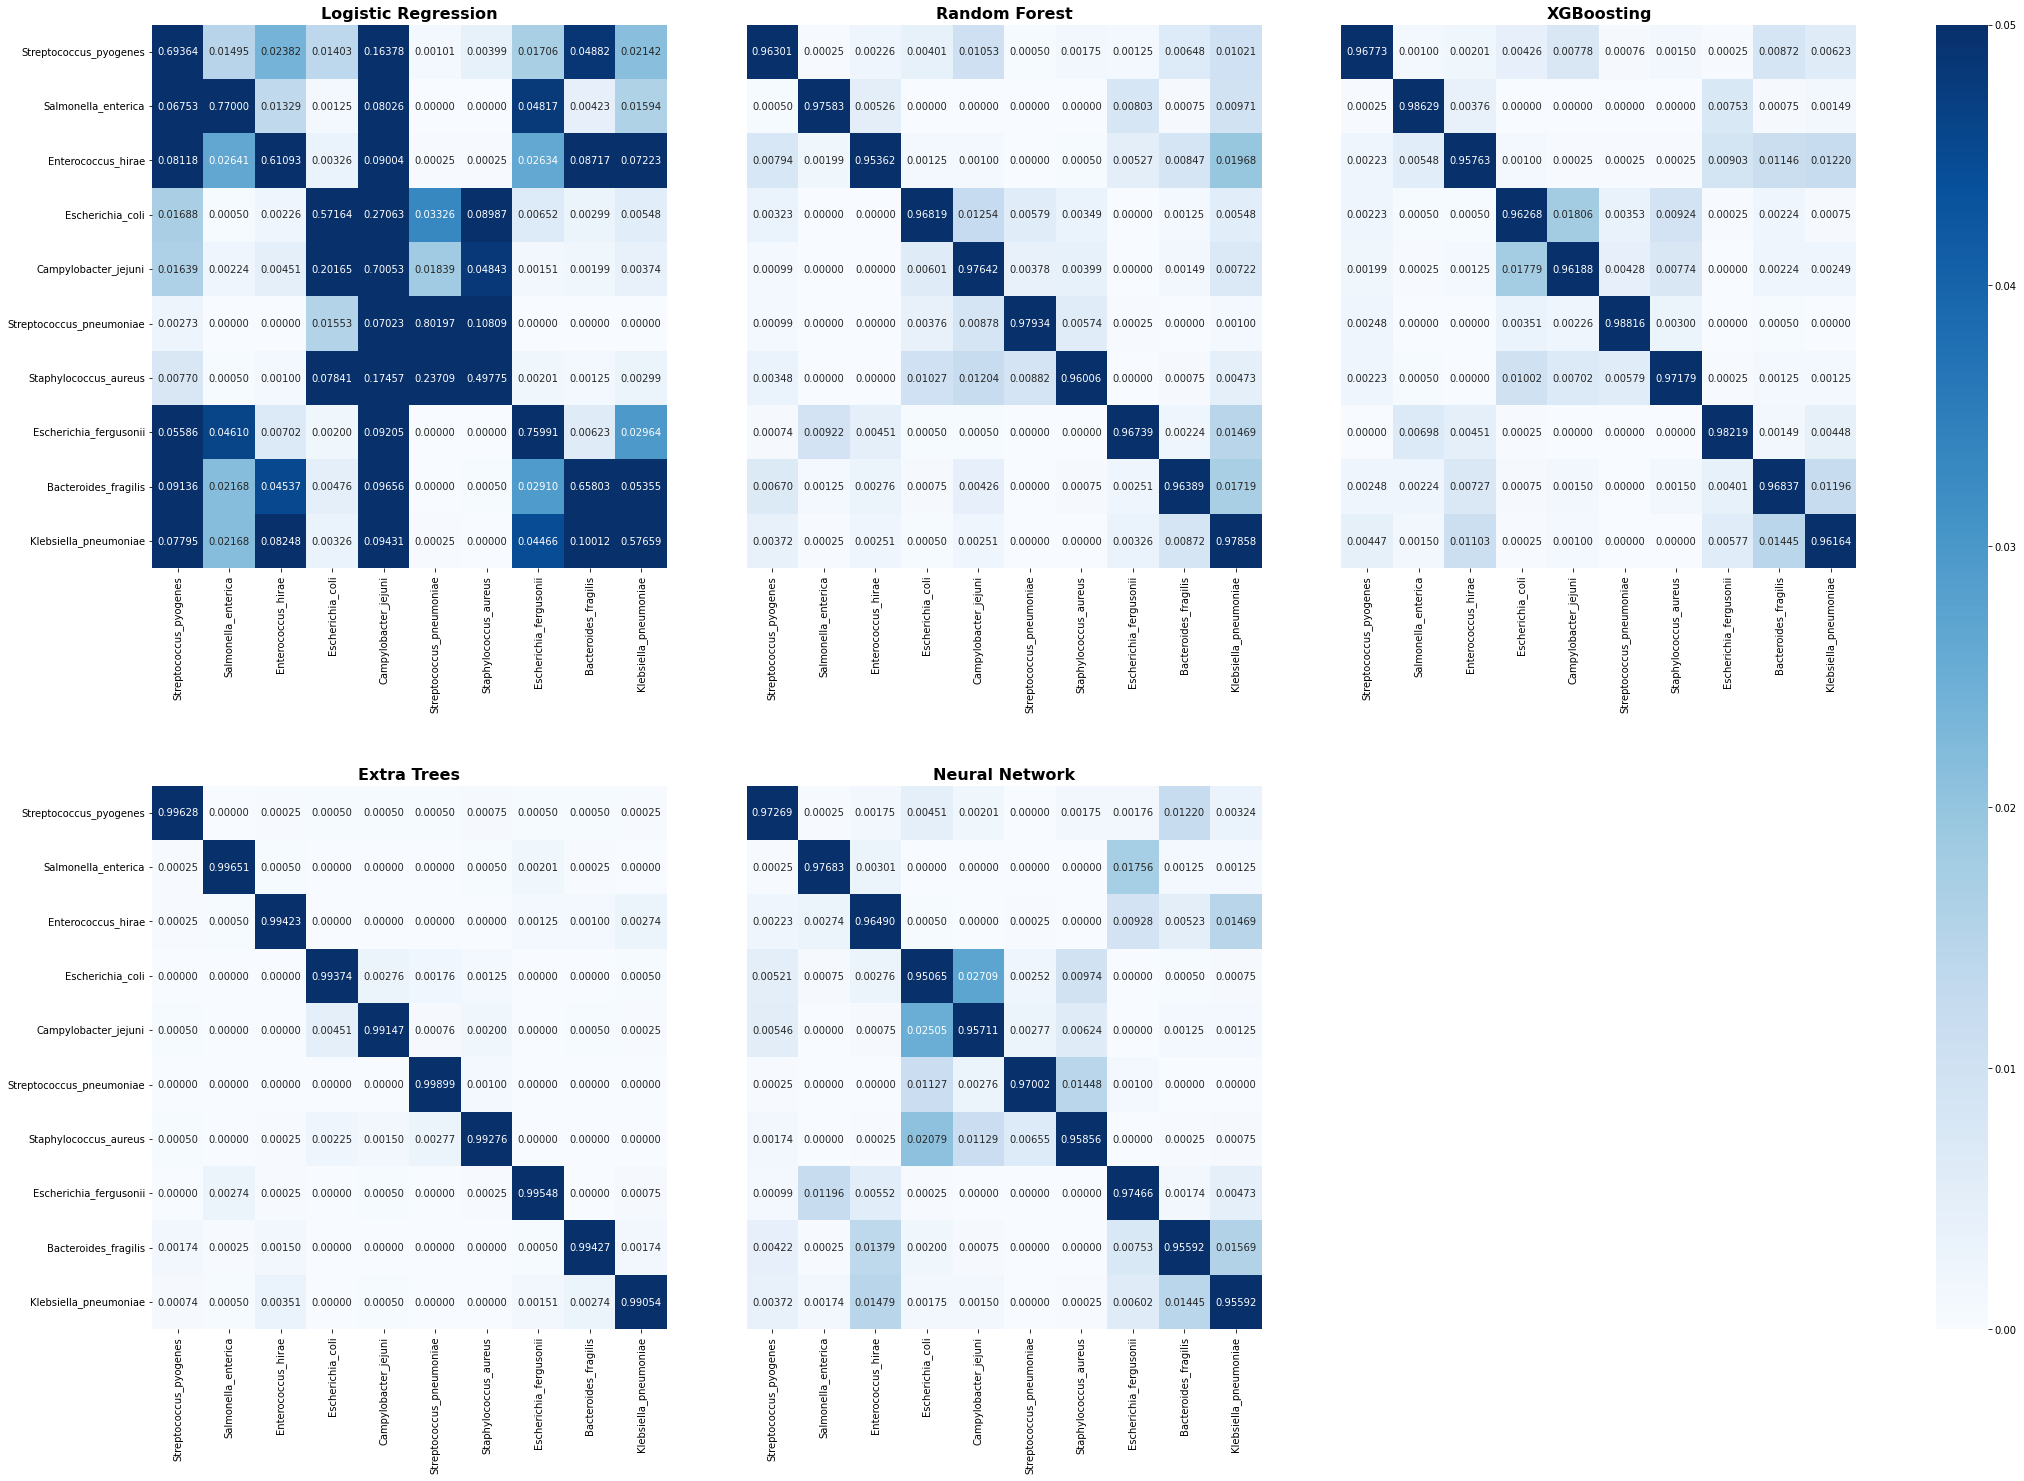

In [139]:
fig = plt.figure(figsize=(30,24))
gs = gridspec.GridSpec(2,4, width_ratios=[1,1,1,0.1], height_ratios=[1,1])
gs.update(left=0.1, right=0.95, wspace=0.2, hspace=0.4)

ax1 = plt.subplot(gs[0,0])
sns.heatmap(cmn_lr, annot=True, fmt='.5f', cmap='Blues', vmin=0.0, vmax=0.05, cbar = False)
ax1.set_xticklabels(labels,rotation=90)
ax1.set_yticklabels(labels,rotation=0)
ax1.set_title("Logistic Regression", fontsize=16,fontweight='bold')

ax2 = plt.subplot(gs[0,1])
sns.heatmap(cmn_rf, annot=True, fmt='.5f', cmap='Blues', vmin=0.0, vmax=0.05, cbar = False, yticklabels=False)
ax2.set_xticklabels(labels,rotation=90)
ax2.set_title("Random Forest", fontsize=16,fontweight='bold')

ax3 = plt.subplot(gs[0,2])
sns.heatmap(cmn_xg, annot=True, fmt='.5f', cmap='Blues', vmin=0.0, vmax=0.05, cbar = False, yticklabels=False)
ax3.set_xticklabels(labels,rotation=90)
ax3.set_title("XGBoosting", fontsize=16,fontweight='bold')

ax4 = plt.subplot(gs[1,0])
sns.heatmap(cmn_et, annot=True, fmt='.5f', cmap='Blues', vmin=0.0, vmax=0.05, cbar = False)
ax4.set_xticklabels(labels,rotation=90)
ax4.set_yticklabels(labels,rotation=0)
ax4.set_title("Extra Trees", fontsize=16,fontweight='bold')

ax6 = plt.subplot(gs[:,3])

ax5 = plt.subplot(gs[1,1])
sns.heatmap(cmn_nn, annot=True, fmt='.5f', cmap='Blues', vmin=0.0, vmax=0.05, cbar = True, cbar_ax=ax6, yticklabels=False)
ax5.set_xticklabels(labels,rotation=90)
ax5.set_title("Neural Network", fontsize=16,fontweight='bold')
# fig.savefig('cm.jpg',dpi=150)